# Exploratory Data Analysis (EDA)

This notebook explores manufacturing downtime data to find key insights to include in the final dashboard.

# Contents
- [Factors Causing Downtime](#Factors-Causing-Downtime)
    - [Analysis Quesiont 01: Which Factors Contribute The Most to Downtime?](#Analysis-Question-01:-Which-Factors-Contribute-The-Most-to-Downtime?)
    - [Analysis Question 02: Which Downtime Factors Occur More Frequently?](#Analysis-Question-02:-Which-Downtime-Factors-Occur-More-Frequently?)
    - [Analysis Question 03: How Much of The Downtime is Associated with Operator Errors?](#Analysis-Quesion-03:-How-Much-of-The-Downtime-is-Associated-with-Operator-Errors?)
    - [Analysis Question 04: Which Operator Causes More Downtime?](#Analysis-Question-04:-Which-Operator-Causes-More-Downtime?)
    - [Analysis Question 05: Does Downtime Occur at Higher Rates for in Products with Certain Flavors?](#Analysis-Question-05:-Does-Downtime-Occur-at-Higher-Rates-for-in-Products-with-Certain-Flavors?)
    - [Analysis Question 06: How Does Product Size Impact The Occurrence of Downtime?](#Analysis-Question-06:-How-Does-Product-Size-Impact-The-Occurrence-of-Downtime?)
    -  [Analysis Question 07: Does Product Size Cause More Downtime Due to Product Spill?](#Analysis-Question-07:-Does-Product-Size-Cause-More-Downtime-Due-to-Product-Spill?)
    -  [Analysis Question 08: Which Products Experience More Downtime?](#Analysis-Questions-08:-Which-Products-Experience-More-Downtime?)
-  [Analysis of Downtime Trends over Time](#Analysis-of-Downtime-Trends-over-Time)
    -  [Analysis Question 09: How Much Production Time Was Lost to Downtime in Total?](#Analysis-Question-09:-How-Much-Production-Time-Was-Lost-to-Downtime-in-Total?)
    -  [Analysis Question 10: How Does Downtime Vary by Work Shifts?](#Analysis-Question-10:-How-Does-Downtime-Vary-by-Work-Shifts?)
    -  [Analysis Question 11: How Does Total Downtime Vary over Time?](#Analysis-Question-11:-How-Does-Total-Downtime-Vary-over-Time?)
-  [Analysis of Downtime Impact](#Analysis-of-Downtime-Impact)
    -  [Analysis Question 12: How Does Downtime Affect Batch Production Rate?](#Analysis-Question-12:-How-Does-Downtime-Affect-Batch-Production-Rate?)

## Import Packages and Load Data

In [1]:
from datetime import datetime
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Load data
source = "../phase-1/clean_data_final.xlsx"
sheet_names = ["Line_productivity", "Calender", "Products", "Product_details", "Downtime_factors", "Line_downtime"]
tables = pd.read_excel(source, sheet_names)

In [3]:
# Merge data
df = pd.merge(
    left=tables["Line_downtime"],
    right=tables["Line_productivity"],
    how="inner",
    on="Batch"
)

# Merge on Downtime Factors
df = df.merge(
    right=tables["Downtime_factors"],
    how="inner",
    on="Factor"
)

# Merge on Products
df = df.merge(
    right=tables["Products"],
    how="inner",
    on="Product"
)

# Merge on Product Details
df = df.merge(
    right=tables["Product_details"],
    how="inner",
    left_on="Size_In_ml",
    right_on="Size"
).drop(columns="Size_In_ml")

# Merge on Calendar
df = df.merge(
    right=tables["Calender"],
    how="inner",
    on="Date"
)

df.rename(columns=lambda x: x.lower(), inplace=True)
df

,batch,factor,minutes,operator,date,start_time,end_time,product,description,operator_error,flavor,size,min_batch_time,year,month,quarter,week_of_month,day_name,month_name
0,422111,2,60,Mac,2024-08-29,11:50:00,14:05:00,OR-600,Batch change,Yes,Orange,600,60,2024,8,3,5,Thursday,August
1,422111,7,15,Mac,2024-08-29,11:50:00,14:05:00,OR-600,Machine failure,No,Orange,600,60,2024,8,3,5,Thursday,August
2,422112,2,20,Mac,2024-08-29,14:05:00,15:45:00,LE-600,Batch change,Yes,Lemon lime,600,60,2024,8,3,5,Thursday,August
3,422112,8,20,Mac,2024-08-29,14:05:00,15:45:00,LE-600,Batch coding error,Yes,Lemon lime,600,60,2024,8,3,5,Thursday,August
4,422113,2,50,Mac,2024-08-29,15:45:00,17:35:00,LE-600,Batch change,Yes,Lemon lime,600,60,2024,8,3,5,Thursday,August
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,422147,4,17,Charlie,2024-09-02,19:30:00,22:55:00,CO-2000,Inventory shortage,No,Cola,2000,98,2024,9,3,1,Monday,September
57,422147,6,60,Charlie,2024-09-02,19:30:00,22:55:00,CO-2000,Machine adjustment,Yes,Cola,2000,98,2024,9,3,1,Monday,September
58,422147,7,30,Charlie,2024-09-02,19:30:00,22:55:00,CO-2000,Machine failure,No,Cola,2000,98,2024,9,3,1,Monday,September
59,422148,4,25,Mac,2024-09-03,22:55:00,01:05:00,CO-2000,Inventory shortage,No,Cola,2000,98,2024,9,3,1,Tuesday,September


## Factors Causing Downtime

#### Analysis Question 01: Which Factors Contribute The Most to Downtime?

In [4]:
# Group data for chart
pareto_df = df.groupby(["description"], as_index=False).agg({
    "minutes": "sum"
})
pareto_df.sort_values(by="minutes", ascending=False, inplace=True, ignore_index=True)
pareto_df["percent"] = round(pareto_df["minutes"] * 100 / pareto_df["minutes"].sum(), 2)
pareto_df["cum_percent"] = round(pareto_df["minutes"].cumsum() * 100 / pareto_df["minutes"].sum(), 2)

# Show data
pareto_df

,description,minutes,percent,cum_percent
0,Machine adjustment,332,23.92,23.92
1,Machine failure,254,18.30,42.22
2,Inventory shortage,225,16.21,58.43
3,Batch change,160,11.53,69.96
4,Batch coding error,145,10.45,80.40
5,Other,74,5.33,85.73
6,Product spill,57,4.11,89.84
7,Calibration error,49,3.53,93.37
8,Labeling error,42,3.03,96.40
9,Label switch,33,2.38,98.78


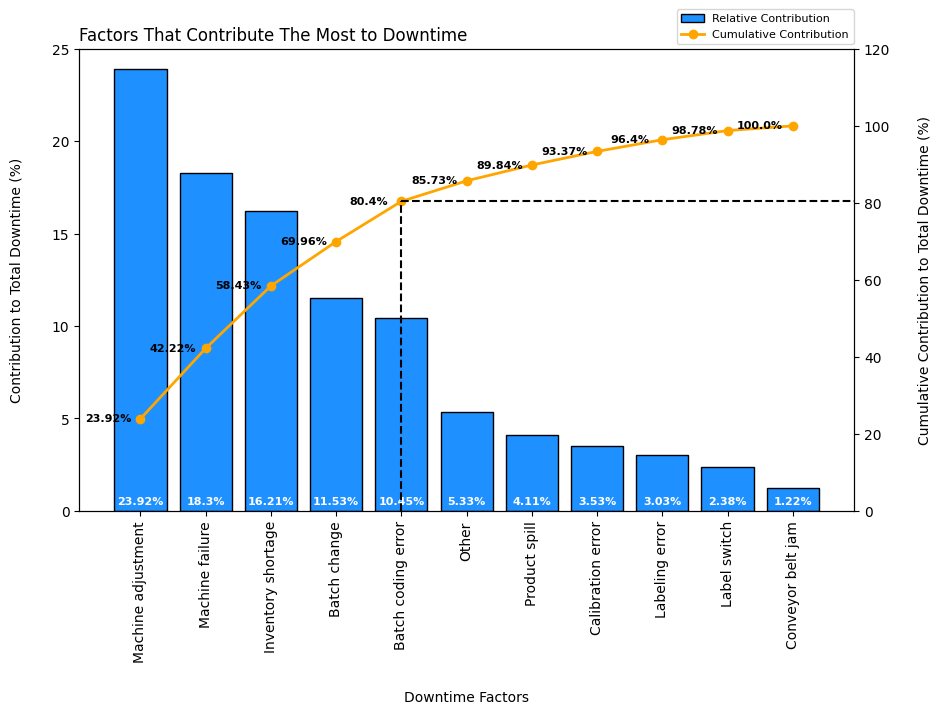

In [5]:
# Plot diagram
fig, ax_bar = plt.subplots(figsize=(10, 6))

xticks = np.arange(len(pareto_df))

# Plot the bar chart
bars = ax_bar.bar(
    x=xticks,
    height=pareto_df["percent"],
    color="dodgerblue",
    edgecolor="black",
    label="Relative Contribution",
    zorder=0
)
ax_bar.set_xticks(xticks)
ax_bar.set_xticklabels(pareto_df["description"], rotation=90)
ax_bar.set_ylabel("Contribution to Total Downtime (%)", labelpad=20)
ax_bar.set_xlabel("Downtime Factors", labelpad=20)
ax_bar.set_title("Factors That Contribute The Most to Downtime", ha="left", x=0)
ax_bar.set_ylim(0, np.ceil(pareto_df.loc[0, "percent"] / 5) * 5)

# Plot the line
ax_line = ax_bar.twinx()
line = ax_line.plot(
    xticks,
    pareto_df["cum_percent"],
    label="Cumulative Contribution",
    color="orange",
    marker="o",
    lw=2,
    zorder=1
)
ax_line.set_ylabel("Cumulative Contribution to Total Downtime (%)", labelpad=20)
ax_line.set_ylim(0, 120)

# Draw dashed line at 80%
x = pareto_df[pareto_df["cum_percent"] >= 80].index[0]
y = pareto_df.loc[x, "cum_percent"]
line_v = Line2D((x, x), (0, y), color="black", ls="--", zorder=2)
line_h = Line2D((x, xticks.max() + 1), (y, y), color="black", ls="--", zorder=2)
ax_line.add_line(line_v)
ax_line.add_line(line_h)

# Add labels
for i in xticks:
    ax_bar.text(i, 0.5, f"{pareto_df.iloc[i, 2]}%", 
                color="white", fontsize=8, fontweight="bold", ha="center", va="center", zorder=3)
    ax_line.text(i - 0.5, pareto_df.loc[i, "cum_percent"], f"{pareto_df.iloc[i, 3]}%", 
                 fontsize=8, fontweight="bold", ha="center", va="center", zorder=3)

# Show legend
fig.legend(bbox_to_anchor=(0.905, 0.955), fontsize=8)

plt.show()

#### Analysis Question 02: Which Downtime Factors Occur More Frequently?

In [6]:
# Group data for chart
factor_dist_df = df.groupby(["description"], as_index=False).agg({"factor":"count"})
factor_dist_df.sort_values(by="factor", ascending=False, ignore_index=True, inplace=True)
factor_dist_df.rename(columns={"description": "factor", "factor":"freq"}, inplace=True)
total = factor_dist_df["freq"].sum()
factor_dist_df["relative_freq"] = round(factor_dist_df["freq"] * 100 / total, 2)

# Show data
factor_dist_df

,factor,freq,relative_freq
0,Machine adjustment,12,19.67
1,Machine failure,11,18.03
2,Inventory shortage,9,14.75
3,Batch coding error,6,9.84
4,Other,6,9.84
5,Batch change,5,8.20
6,Calibration error,3,4.92
7,Label switch,3,4.92
8,Product spill,3,4.92
9,Labeling error,2,3.28


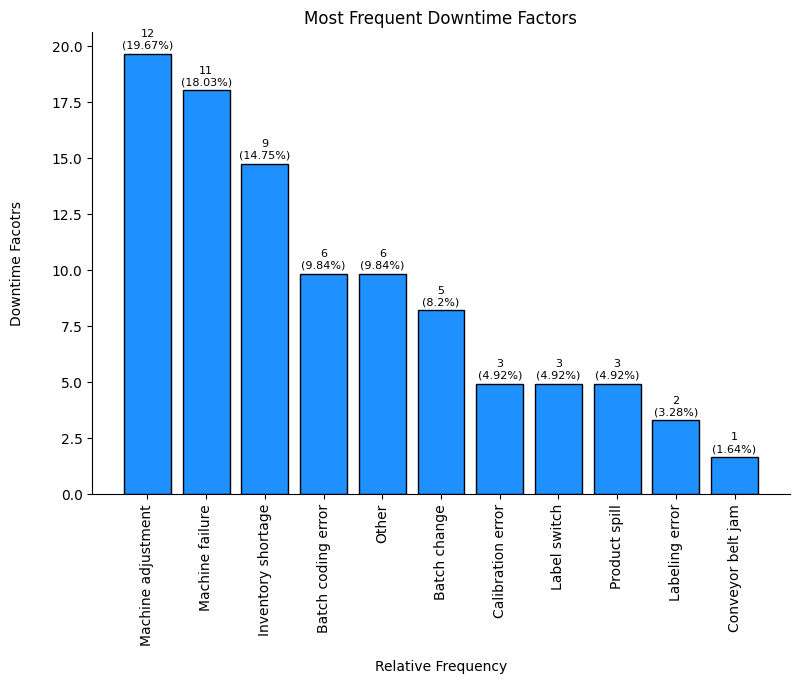

In [7]:
fig, ax = plt.subplots(figsize=(9, 6))

# Plot bars
x = np.arange(len(factor_dist_df))
bars = ax.bar(x, factor_dist_df["relative_freq"], color="dodgerblue", edgecolor="black")
ax.set_xticks(x)
ax.set_xticklabels(factor_dist_df["factor"], rotation=90)
ax.set_xlabel("Relative Frequency", labelpad=10)
ax.set_ylabel("Downtime Facotrs", labelpad=20)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Most Frequent Downtime Factors")

# Add labels
for x in xticks:
    ax.text(x, bars[x].get_height() + 0.25, f"{factor_dist_df.loc[x, 'freq']}\n({factor_dist_df.loc[x, 'relative_freq']}%)", fontsize=8, ha="center")

plt.show()

#### Analysis Quesion 03: How Much of The Downtime is Associated with Operator Errors?

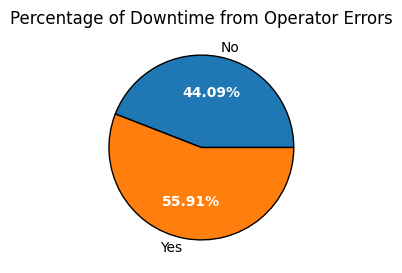

In [8]:
# Group data for chart
pie_df = df.groupby(["operator_error"], as_index=False).agg({"minutes":"sum"})

# Plot pie
fig, ax = plt.subplots(figsize=(5, 3))

wedges, texts, autotexts = ax.pie(pie_df["minutes"], labels=pie_df["operator_error"], autopct="%0.2f%%",
      wedgeprops={"edgecolor":"black"})
ax.set_title("Percentage of Downtime from Operator Errors")

for text in autotexts:
    text.set_color("white")
    text.set_weight("bold")

plt.show()

#### Analysis Question 04: Which Operator Causes More Downtime?

In [9]:
# Group data for chart
operator_downtime = df[df["operator_error"] == "Yes"].groupby("operator", as_index=False)["minutes"].sum()
operator_downtime = operator_downtime.sort_values(by="minutes", ascending=False, ignore_index=True)
operator_downtime["minutes"] = operator_downtime["minutes"].round(2)

# Show data
operator_downtime

,operator,minutes
0,Charlie,228
1,Dee,192
2,Mac,192
3,Dennis,164


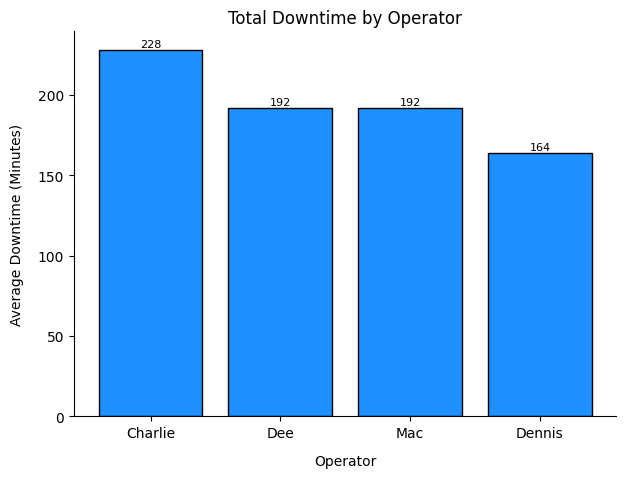

In [10]:
fig, ax = plt.subplots(figsize=(7, 5))

# Plot the chart
x = np.arange(len(operator_downtime))
ax.bar(x, operator_downtime["minutes"], color="dodgerblue", edgecolor="black")
ax.set_xticks(x)
ax.set_xticklabels(operator_downtime["operator"])
ax.set_xlabel("Operator", labelpad=10)
ax.set_ylabel("Average Downtime (Minutes)", labelpad=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Total Downtime by Operator")

# Add data labels
for i in x:
    ax.text(i, operator_downtime.loc[i, "minutes"] + 1.5, f"{operator_downtime.loc[i, 'minutes']}",
           fontsize=8, ha="center")

plt.show()

#### Analysis Question 05: Does Downtime Occur at Higher Rates for in Products with Certain Flavors?

In [11]:
# Group data
flavor_aggregated_df = df.groupby("flavor", as_index=False)["minutes"].sum().sort_values(by="minutes", ascending=False, ignore_index=True)
flavor_aggregated_df["minutes"] = flavor_aggregated_df["minutes"].round(2)
flavor_aggregated_df

,flavor,minutes
0,Cola,771
1,Root Berry,258
2,Lemon lime,169
3,Diet Cola,115
4,Orange,75


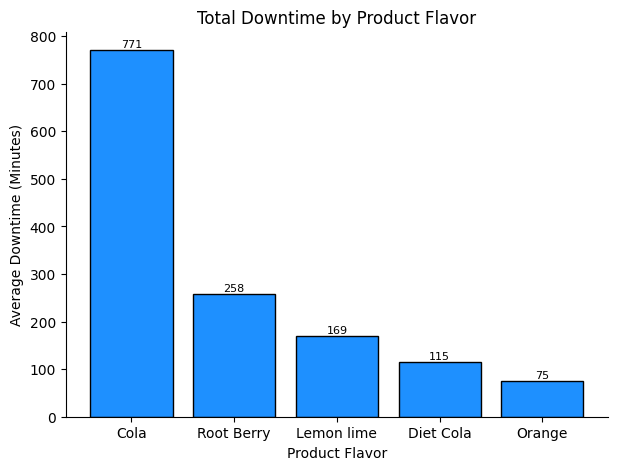

In [12]:
fig, ax = plt.subplots(figsize=(7, 5))

xticks = np.arange(len(flavor_aggregated_df))
ax.bar(xticks, flavor_aggregated_df["minutes"], color="dodgerblue", edgecolor="black")
ax.set_xticks(xticks)
ax.set_xticklabels(flavor_aggregated_df["flavor"])
ax.set_xlabel("Product Flavor")
ax.set_ylabel("Average Downtime (Minutes)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Total Downtime by Product Flavor")

for x in xticks:
    ax.text(x, flavor_aggregated_df.loc[x, "minutes"] + 5.5, f"{flavor_aggregated_df.loc[x, 'minutes']}", fontsize=8, ha="center")

plt.show()

#### Analysis Question 06: How Does Product Size Impact The Occurrence of Downtime?

In [13]:
prod_size_aggregated_df = df.groupby("size", as_index=False)["minutes"].sum()
prod_size_aggregated_df["size"] = prod_size_aggregated_df["size"].astype(str) + " ml"
prod_size_aggregated_df["minutes"] = prod_size_aggregated_df["minutes"].round(2)
prod_size_aggregated_df

,size,minutes
0,600 ml,1111
1,2000 ml,277


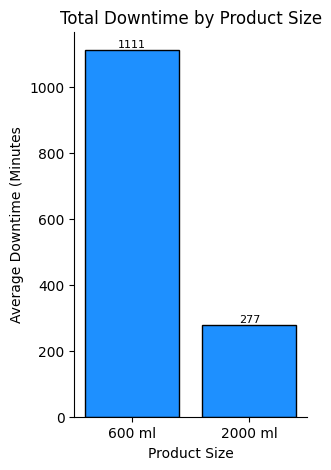

In [14]:
fig, ax = plt.subplots(figsize=(3, 5))

xticks = np.arange(len(prod_size_aggregated_df))
ax.bar(xticks, prod_size_aggregated_df["minutes"], color="dodgerblue", edgecolor="black")
ax.set_xticks(xticks)
ax.set_xticklabels(prod_size_aggregated_df["size"])
ax.set_xlabel("Product Size")
ax.set_ylabel("Average Downtime (Minutes")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Total Downtime by Product Size")

for x in xticks:
    ax.text(x, prod_size_aggregated_df.loc[x, "minutes"] + 7.5, f"{prod_size_aggregated_df.loc[x, 'minutes']}", fontsize=8, ha="center")

plt.show()

#### Analysis Question 07: Does Product Size Cause More Downtime Due to Product Spill?

In [15]:
# What is the relation between product spill and product size?
aggregated_df = df[df["factor"] == 5].groupby("size", as_index=False)["minutes"].sum()
aggregated_df["size"] = aggregated_df["size"].astype(str) + " ml"
aggregated_df["minutes"] = aggregated_df["minutes"].round(2)
aggregated_df

,size,minutes
0,600 ml,57


#### Analysis Questions 08: Which Products Experience More Downtime?

In [16]:
# Calculate total downtime per product
product_downtime = df.groupby(["product","flavor"])["minutes"].sum().reset_index()
product_downtime = product_downtime.sort_values(by="minutes", ascending=False).reset_index(drop=True)

print(product_downtime)  # Products by downtime

   product      flavor  minutes
0   CO-600        Cola      494
1  CO-2000        Cola      277
2   RB-600  Root Berry      258
3   LE-600  Lemon lime      169
4   DC-600   Diet Cola      115
5   OR-600      Orange       75


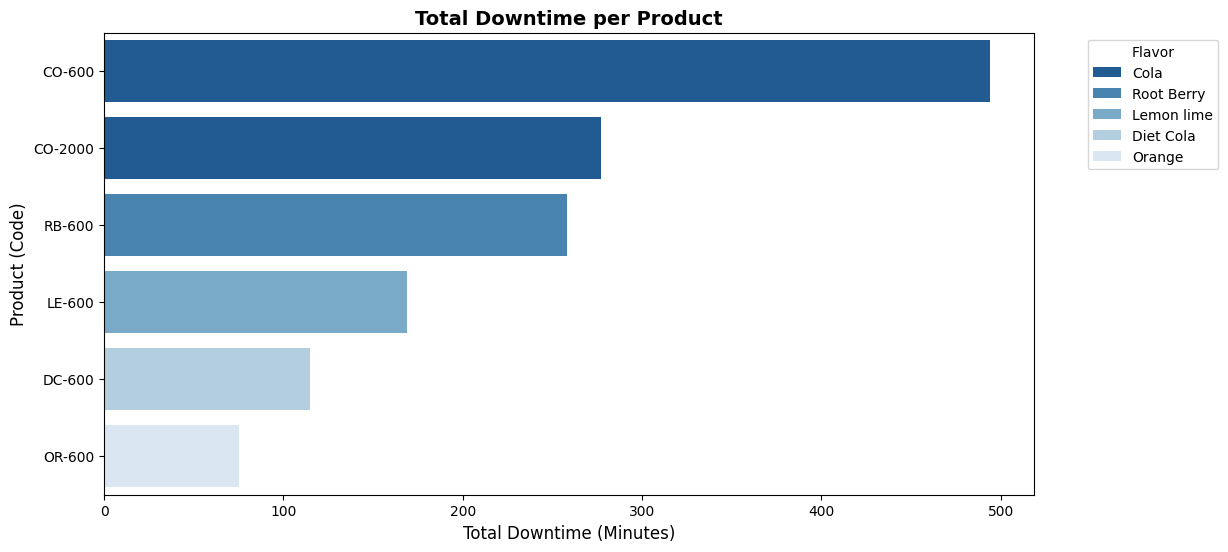

In [17]:
# Set figure size
plt.figure(figsize=(12, 6))

# Create bar plot with Flavor as hue
sns.barplot(data=product_downtime, x="minutes", y="product", hue="flavor", dodge=False, palette="Blues_r")

# Customize labels and title
plt.xlabel("Total Downtime (Minutes)", fontsize=12)
plt.ylabel("Product (Code)", fontsize=12)
plt.title("Total Downtime per Product", fontsize=14, fontweight="bold")
plt.legend(title="Flavor", bbox_to_anchor=(1.05, 1), loc="upper left") # Move legend outside the plot
plt.show()

## Analysis of Downtime Trends over Time

#### Analysis Question 09: How Much Production Time Was Lost to Downtime in Total?

In [18]:
# Total downtime
total_downtime_minutes = df["minutes"].sum()

# Convert to hours
total_downtime_hours = total_downtime_minutes / 60

print(f"Total Downtime: {total_downtime_hours:.2f} hours")

Total Downtime: 23.13 hours


#### Analysis Question 10: How Does Downtime Vary by Work Shifts?

In [19]:
# Function to categorize shifts
def categorize_shift(time):
    hour = time.hour  # Directly access hour from datetime.time
    if 6 <= hour < 14:
        return "Morning"
    elif 14 <= hour < 22:
        return "Afternoon"
    else:
        return "Night"

# Cast start time as datetime.time and apply shift categorization
df["start_time"] = df["start_time"].apply(lambda x: datetime.strptime(x, "%H:%M:%S").time())
df["shift"] = df["start_time"].apply(categorize_shift)

# Group by Shift and sum downtime
df_shift_downtime = df.groupby("shift")["minutes"].sum().reset_index()

print(df_shift_downtime)

       shift  minutes
0  Afternoon      584
1    Morning      534
2      Night      270


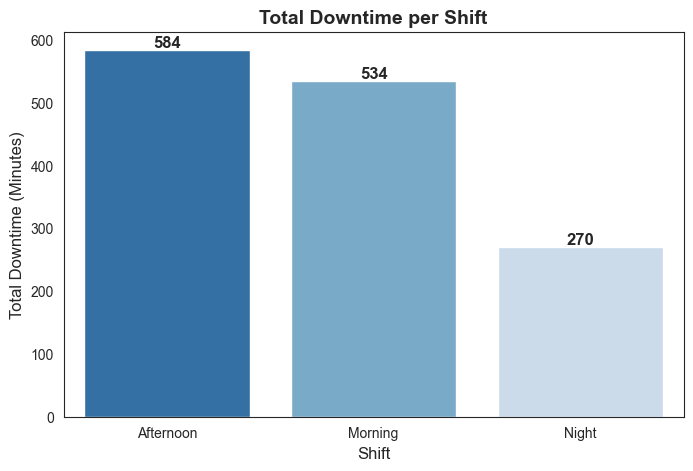

In [20]:
# Set seaborn style
sns.set_style("white")

# Plot the bar chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="shift", y="minutes", data=df_shift_downtime, palette="Blues_r", hue="shift")

# Add labels & title
plt.xlabel("Shift", fontsize=12)
plt.ylabel("Total Downtime (Minutes)", fontsize=12)
plt.title("Total Downtime per Shift", fontsize=14, fontweight="bold")

# Show the values on top of bars
for p in ax.patches:  # ax.patches is a list of all bars in the bar chart
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2, p.get_height()), #Positioning the Label
                ha="center", va="bottom", fontsize=12, fontweight="bold")

plt.show()

#### Analysis Question 11: How Does Total Downtime Vary over Time?

In [21]:
grouped_date = df.groupby("date")["minutes"].sum()
grouped_date = grouped_date.resample("D").sum().fillna(0)
grouped_date = grouped_date.reset_index()
grouped_date

,date,minutes
0,2024-08-29,244
1,2024-08-30,444
2,2024-08-31,165
3,2024-09-01,0
4,2024-09-02,503
5,2024-09-03,32


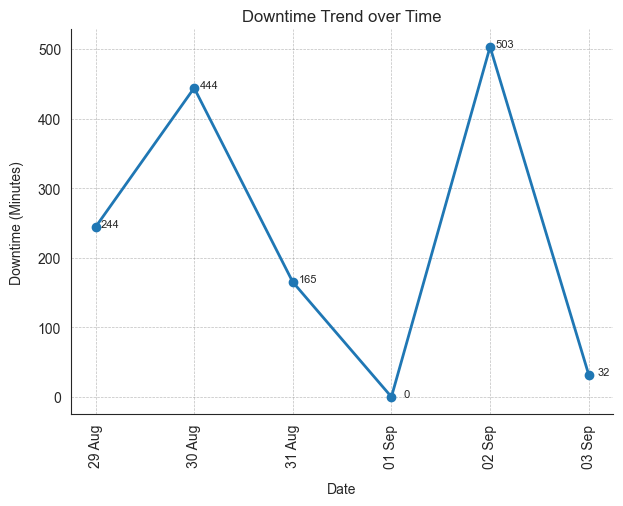

In [22]:
fig, ax = plt.subplots(figsize=(7, 5))

xticks = np.arange(len(grouped_date))
xlabels = grouped_date["date"].dt.strftime("%d %b")
ax.plot(xticks, grouped_date["minutes"], lw=2, marker="o")
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=90)
ax.set_xlabel("Date", labelpad=10)
ax.set_ylabel("Downtime (Minutes)", labelpad=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Downtime Trend over Time")
ax.grid(True, which="major", color="gray", ls="--", lw=0.5, alpha=0.5)

for x in xticks:
    ax.text(x + 0.15, grouped_date.loc[x, "minutes"], f"{grouped_date.loc[x, 'minutes']}", fontsize=8, ha="center")

plt.show()

## Analysis of Downtime Impact

#### Analysis Question 12: How Does Downtime Affect Batch Production Rate?

In [23]:
merged = pd.merge(
    left=tables["Line_downtime"],
    right=tables["Line_productivity"],
    on="Batch",
    how="outer"
)

merged = merged.merge(
    right=tables["Products"],
    on="Product",
    how="inner"
)

merged = merged.merge(
    right=tables["Product_details"],
    left_on="Size_In_ml",
    right_on="Size",
    how="inner"
).rename(columns=lambda x: x.lower().replace(" ", "_"))

merged = merged.fillna({"minutes": 0})
merged

,batch,factor,minutes,operator,date,start_time,end_time,product,flavor,size_in_ml,size,min_batch_time
0,422111,2.0,60.0,Mac,2024-08-29,11:50:00,14:05:00,OR-600,Orange,600,600,60
1,422111,7.0,15.0,Mac,2024-08-29,11:50:00,14:05:00,OR-600,Orange,600,600,60
2,422112,2.0,20.0,Mac,2024-08-29,14:05:00,15:45:00,LE-600,Lemon lime,600,600,60
3,422112,8.0,20.0,Mac,2024-08-29,14:05:00,15:45:00,LE-600,Lemon lime,600,600,60
4,422113,2.0,50.0,Mac,2024-08-29,15:45:00,17:35:00,LE-600,Lemon lime,600,600,60
...,...,...,...,...,...,...,...,...,...,...,...,...
59,422147,4.0,17.0,Charlie,2024-09-02,19:30:00,22:55:00,CO-2000,Cola,2000,2000,98
60,422147,6.0,60.0,Charlie,2024-09-02,19:30:00,22:55:00,CO-2000,Cola,2000,2000,98
61,422147,7.0,30.0,Charlie,2024-09-02,19:30:00,22:55:00,CO-2000,Cola,2000,2000,98
62,422148,4.0,25.0,Mac,2024-09-03,22:55:00,01:05:00,CO-2000,Cola,2000,2000,98


In [24]:
aggregated_df = merged.groupby("date", as_index=False).agg({
    "batch": "nunique",
    "minutes": "sum",
    "start_time": "min",
    "end_time": "max",
    "min_batch_time": "mean"  # for use in next question
})

aggregated_df["start_time"] = pd.to_datetime(aggregated_df["date"].astype(str) + " " + aggregated_df["start_time"].astype(str))
aggregated_df["end_time"] = pd.to_datetime(aggregated_df["date"].astype(str) + " " + aggregated_df["end_time"].astype(str))
aggregated_df["work_time"] = (aggregated_df["end_time"] - aggregated_df["start_time"]).dt.total_seconds() / 3600
aggregated_df["work_time"] = aggregated_df["work_time"].apply(lambda x: x + 24 if x < 0 else x).round(0)
aggregated_df["batches_per_hour"] = (aggregated_df["batch"] / aggregated_df["work_time"]).round(2)
aggregated_df

,date,batch,minutes,start_time,end_time,min_batch_time,work_time,batches_per_hour
0,2024-08-29,7,244.0,2024-08-29 11:50:00,2024-08-29 22:54:00,60.0,11.0,0.64
1,2024-08-30,12,444.0,2024-08-30 04:05:00,2024-08-30 23:29:00,60.0,19.0,0.63
2,2024-08-31,7,165.0,2024-08-31 07:45:00,2024-08-31 17:30:00,60.0,10.0,0.70
3,2024-09-02,11,503.0,2024-09-02 01:00:00,2024-09-02 22:55:00,77.1,22.0,0.50
4,2024-09-03,1,32.0,2024-09-03 22:55:00,2024-09-03 01:05:00,98.0,2.0,0.50


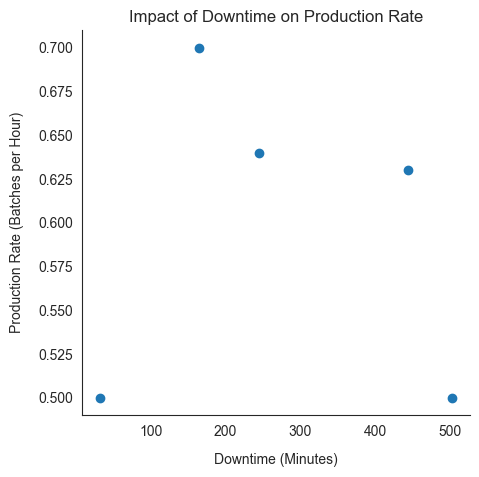

In [25]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(aggregated_df["minutes"], aggregated_df["batches_per_hour"])
ax.set_xlabel("Downtime (Minutes)", labelpad=10)
ax.set_ylabel("Production Rate (Batches per Hour)", labelpad=10)
ax.set_title("Impact of Downtime on Production Rate")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

## Further Exploration

#### Does Any of the Operators Cause More Downtime Due to Machine Adjustment than the Others?

In [26]:
# Filter data
machine_adjustment_df = df[df["factor"] == 6]

# Aggregate downtime by Operators
machine_adjustment_df.groupby("operator")["minutes"].sum()

operator
Charlie    118
Dee         79
Dennis     120
Mac         15
Name: minutes, dtype: int64

#### Does Downtime from Inventory Shortage Occur for Products with Specific Flavors?

In [28]:
# Aggregation of total downtime by each flavor
flavors = df.groupby("flavor")["minutes"].sum()
flavors

flavor
Cola          771
Diet Cola     115
Lemon lime    169
Orange         75
Root Berry    258
Name: minutes, dtype: int64

In [29]:
# Filter data
inv_short_df = df[df["factor"] == 4]

# Aggregate downtime by flavors
inv_short_df = inv_short_df.groupby("flavor")["minutes"].sum()
inv_short_df

flavor
Cola          150
Diet Cola      30
Lemon lime     25
Root Berry     20
Name: minutes, dtype: int64

In [30]:
# Downtime from inventory shortage in each flavor as a percent of total downtime in the flavor
(inv_short_df * 100 / flavors).fillna(0).round(2)

flavor
Cola          19.46
Diet Cola     26.09
Lemon lime    14.79
Orange         0.00
Root Berry     7.75
Name: minutes, dtype: float64

In [31]:
# Downtime due to inventory shortage for each flavor relative to total downtime from inventory shortage
inv_short_relative = (inv_short_df * 100 / inv_short_df.sum()).round(2)
inv_short_relative

flavor
Cola          66.67
Diet Cola     13.33
Lemon lime    11.11
Root Berry     8.89
Name: minutes, dtype: float64

In [32]:
cola = inv_short_relative["Cola"] + inv_short_relative["Diet Cola"]
print(f"Downtime due to inventory shortage in cola-flavored products: {cola}%")

Downtime due to inventory shortage in cola-flavored products: 80.0%


#### Which Operator Causes More Downtime Due to Batch Changes?

In [33]:
# Filter data
batch_change_df = df[df["factor"] == 2]

# Aggregate by operators
batch_change_df.groupby("operator")["minutes"].sum()

operator
Charlie     10
Dee         20
Mac        130
Name: minutes, dtype: int64

#### Does Downtime Due to Batch Change Occur with Specific Flavors?

In [34]:
batch_change_flavor = batch_change_df.groupby("flavor")["minutes"].sum()
batch_change_flavor

flavor
Cola          20
Lemon lime    80
Orange        60
Name: minutes, dtype: int64

In [35]:
# As a percent of total
(batch_change_flavor * 100 / batch_change_flavor.sum()).round(2)

flavor
Cola          12.5
Lemon lime    50.0
Orange        37.5
Name: minutes, dtype: float64

87.5% of the downtime due to batch change occurs with products that are not cola-flavored. This might indicate that cola products are produced more frequently and downtime due to batch change occurs when swtiching to products with a different flavor.

In [36]:
# Frequency distribution of product flavors
flavor_freq = pd.merge(
    left=tables["Line_productivity"],
    right=tables["Products"],
    on="Product",
    how="inner"
)["Flavor"].value_counts().reset_index()
flavor_freq["relative_freq"] = (flavor_freq["count"] * 100 / flavor_freq["count"].sum()).round(2)
flavor_freq.set_index("Flavor", inplace=True)
flavor_freq

,count,relative_freq
Flavor,,
Cola,20,52.63
Root Berry,7,18.42
Lemon lime,6,15.79
Diet Cola,4,10.53
Orange,1,2.63


In [37]:
percent = (flavor_freq.loc["Cola", "relative_freq"] + flavor_freq.loc["Diet Cola", "relative_freq"]).round(2)
print(f"{percent}% of the batches produced were cola-flavored.")

63.16% of the batches produced were cola-flavored.


This shows that the cola flavor is consistently produced and propably switched to less often.

#### Which Operator Causes More Downtime Due to Batch Coding Errors?

In [38]:
# Filter data
batch_coding_df = df[df["factor"] == 8]

# Aggregate downtime by operator
batch_coding_df.groupby("operator")["minutes"].sum()

operator
Charlie    44
Dee        30
Dennis     24
Mac        47
Name: minutes, dtype: int64